# Simulation of a positron-induced Muon Source

### Cross section computation:
* *Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$)*

Both differential and total cross section in the CoM reference system are computed in the limit of $\sqrt{s}\sim 2m_\mu \gg m_e$, $m_e$ is thus discarded. $\theta$ is considered as the angle of the outcoming $\mu^+$ with respect to the incoming $e^+$ direction (which we call x axis). The scatttering is planar and the final distribution is isotropic with respect to $\varphi$ angle around x axis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
e_ = 1.60217662e-19 # C
c_ = 299792458

# ------------------- total cross section calculation ------------------------------

def xsec(sqrs):      # cross section computed for sqrt(s)~2m_mu, disarding m_e. 
                     # e+e- Center of Mass reference system
    alpha = 1./137.
    mmu = 0.1056583715 # GeV/c2
    
    sqrs=np.array(sqrs)
    sqrs_loc=sqrs.copy()
    mask = (sqrs_loc/mmu < 2)    # s is set to inf when less than threshold to have zero cross section
    sqrs_loc[mask] = 9999
    sigma = (4.*pi*alpha**2)/3./(sqrs_loc**2)*np.sqrt(1.-4.*(mmu/sqrs_loc)**2)*(1.+2.*(mmu/sqrs_loc)**2)
    sigma_mub = 389.379 * sigma   # conversion from GeV-2 to mubarn
    return sigma_mub

xx = np.arange(0.21,0.23,0.0001)
yy = xsec(xx)

plt.figure(figsize=(6,4))
plt.subplot(111)
plt.plot(xx,yy)
plt.xlabel(r'$\sqrt{s}$ [Gev]')
plt.ylabel(r'$\sigma$ [$\mu$b]')
plt.title(r'$e^+e^-\rightarrow\mu^+\mu^-$ total cross section')

Text(0.5, 1.0, '$e^+e^-\\rightarrow\\mu^+\\mu^-$ total cross section')

* *Compute and display the angle and momentum components distributions of the emerging muon pairs.*

The differential cross section is computed as a function of $\cos{\theta}$ to get the angular distributon of produced muon pairs.

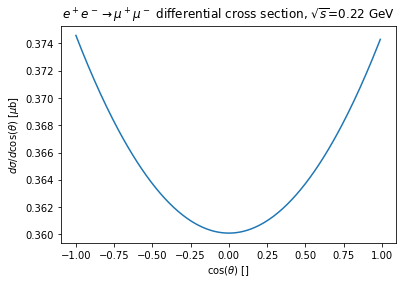

In [2]:
# ----------------- differential cross section calculation -------------

def xsec_diff(sqrs2,cos):   # differential cross section (N.B.: already integrated over phi!!)
    alpha = 1./137.
    mmu = 0.1056583715 # GeV/c2
    sqrs2=np.array(sqrs2)
    
    sqrs_loc=sqrs2.copy()
    mask = (sqrs_loc/mmu < 2)
    sqrs_loc[mask] = 9999
    beta = np.sqrt(1.-4.*mmu*mmu/(sqrs_loc**2))
    dsigma = pi/2.*alpha*alpha/(sqrs_loc**2)*beta*(1+(2.*mmu/sqrs_loc)**2+(beta*cos)**2)
    
    return 389.379*dsigma

xxcos=np.arange(-1,1,0.01)
rads=0.22

plt.figure(figsize=(6,4))
plt.subplot(111)
plt.plot(xxcos,xsec_diff(rads,xxcos))
plt.xlabel(r'$\cos{(\theta)}$ []')
plt.ylabel(r'$d\sigma/d\cos{(\theta)}$ [$\mu$b]')
plt.title(r'$e^+e^-\rightarrow\mu^+\mu^-$ differential cross section, $\sqrt{s}$=0.22 GeV')
plt.show()

* *Write a Monte Carlo simulation that generates scattering events following the distrubtions that you find analytically.* 

$\cos{\theta}$ is sampled using the inverse transformation method. The distribution we get is coherent with the distribution found analytically. The distribution looks "dirt" because at these low energy the curvature of the distribution parabola (i.e. the different probability density for minima and maxima) are very small.

In [3]:
from scipy.optimize import brentq
%precision 8

# ---------- Monte Carlo cosTheta sampling with inverse transformation method -------

N=100000
s=rads**2

def f(x, s, k):
    alpha = 1./137.
    mmu = 0.1056583715
    beta = np.sqrt(1.-4.*(mmu)**2/(s))   ####(alpha/4.*s)*beta*
    return ( ( (1. + (4.*mmu**2)/s + ((beta*x)**2)/3.)*x + 1. + (4.*mmu**2)/s + (beta**2)/3 )/
            (2*(1. + (4.*mmu**2)/s + ((beta)**2)/3.)) - k )


k_arr=np.random.random(N)

#xf = np.arange(-2, 2, 0.001)
#plt.plot(xf, f(xf, s, k))
cos_arr=[brentq(f, -1, 1, args=(s, kk)) for kk in k_arr]
#brentq(f, -1, 1, args=(s, k))

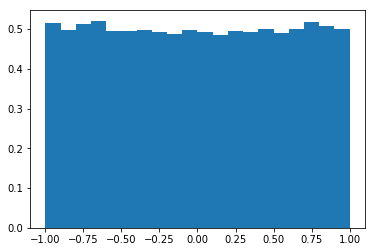

In [4]:
plt.hist(cos_arr, bins=20, density=True)
#plt.ylim(0.45, 0.55)
plt.show()

$\varphi$ angle is sampled from a uniform distribution from 0 to $2\pi$.

In [5]:
# ------ Monte Carlo phi sampling from uniform distribution -------
phi = 2*pi*np.random.random(N)

An alternative methond to sample $\cos\Theta$ is the "rejection sampling" (Accept-reject method). The result is very similar to what was obtained with previous method, thus in this case the procedures are equivalent. The analitycal distribution is plotted on top for comparison.

(0.45000000, 0.55000000)

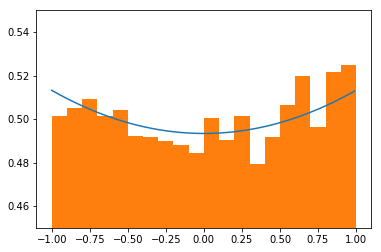

In [6]:
from scipy.integrate import quad
%precision 8

rads=0.22

def xsec_diff_norm(cos, sqrs2):   # differential cross section (N.B.: already integrated over phi!!)
    alpha = 1./137.
    mmu = 0.1056583715 # GeV/c2
    sqrs2=np.array(sqrs2)
    
    sqrs_loc=sqrs2.copy()
    mask = (sqrs_loc/mmu < 2)
    sqrs_loc[mask] = 9999
    beta = np.sqrt(1.-4.*mmu*mmu/(sqrs_loc**2))
    dsigma = pi/2.*alpha*alpha/(sqrs_loc**2)*beta*(1+(2.*mmu/sqrs_loc)**2+(beta*cos)**2)
    
    return 389.379*dsigma/xsec(sqrs2)

plt.plot(xxcos,xsec_diff_norm(xxcos,rads))


upper = xsec_diff_norm(-1, rads)


u = np.random.uniform(-1, 1, N)
r = np.random.uniform(0, upper, N)
v = u[r < xsec_diff_norm(u,rads)]

plt.hist(v, bins=20, density=True)
plt.ylim(0.45, 0.55)



* *About $N=10^5$ (or more) of such events should be produced and listed as rows in a file with 6 columns representing the muon pair tri-momenta*

In [7]:
import pandas as pd

# ------ preliminar dataset creation -------

data = pd.DataFrame(
    {
        'cosTheta': cos_arr,
        'phi': phi
    }
)

data['sinTheta'] = np.sqrt(1-data['cosTheta']**2)


In [8]:
mmu = 0.1056583715   # GeV/c2
p = np.sqrt( rads**2/(2)**2 - mmu**2 )

momentum = pd.DataFrame()

momentum['p1x'] = p*data['sinTheta']*np.cos(data['phi'])
momentum['p1y'] = p*data['cosTheta']*np.sin(data['phi'])
momentum['p1z'] = p*data['cosTheta']

momentum['p2x'] = -momentum['p1x']
momentum['p2y'] = -momentum['p1y']
momentum['p2z'] = -momentum['p1z']

momentum

,p1x,p1y,p1z,p2x,p2y,p2z
0,-0.022176,-0.006189,-0.019777,0.022176,0.006189,0.019777
1,0.015932,0.014492,0.019905,-0.015932,-0.014492,-0.019905
2,-0.020794,0.006107,0.008653,0.020794,-0.006107,-0.008653
3,0.017660,0.004111,0.024812,-0.017660,-0.004111,-0.024812
4,0.029379,0.000939,-0.003698,-0.029379,-0.000939,0.003698
5,0.021338,-0.009259,0.016695,-0.021338,0.009259,-0.016695
6,0.015603,0.014994,-0.021282,-0.015603,-0.014994,0.021282
7,0.029667,-0.000892,-0.004513,-0.029667,0.000892,0.004513
8,0.012582,-0.013423,0.015247,-0.012582,0.013423,-0.015247
9,0.018867,0.009106,0.012320,-0.018867,-0.009106,-0.012320


In [9]:
me = 0.000511

beta_rel = - np.sqrt( 1. - (4.*me**2)/rads**2 )
gamma_rel = 1./np.sqrt(1-beta_rel**2)

mom_lab_frame = pd.DataFrame()

mom_lab_frame['p1x'] = momentum['p1x']
mom_lab_frame['p1y'] = momentum['p1y']
mom_lab_frame['p1z'] = gamma_rel*momentum['p1z'] - beta_rel*gamma_rel*rads/2
mom_lab_frame['p2x'] = momentum['p2x']
mom_lab_frame['p2y'] = momentum['p2y']
mom_lab_frame['p2z'] = gamma_rel*momentum['p2z'] - beta_rel*gamma_rel*rads/2

#mom_lab_frame

* *Assume a $6$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.*

**calcolare luminosità integrata**

In [10]:
rhoBe = 1848e3 # g/m^3
amBe = 9.012182 # u
thikBe = 0.06 # m
ratePos = 1e6
n_av = 6.022e23

L = 4 * ((rhoBe * n_av) / amBe) * thikBe * ratePos

Rate = xsec(rads) * 1e-34 * L

evt_week = Rate * 7 * 24 * 60 * 60

scaling_factor = evt_week/N

print(scaling_factor)

13.081858869906545


* *Repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV.*
**questa è la parte difficile. anche il beam va campionato**

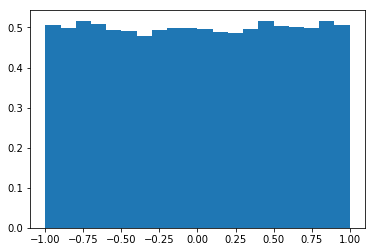

In [11]:
%precision 8
N = 100000
sigma_en = 0.5
T_boil_Be = 2742 # K
rads = 0.22


beta_rel = - np.sqrt( 1. - (4.*me**2)/rads**2 )
gamma_rel = 1./np.sqrt(1-beta_rel**2)
en_lab = gamma_rel * rads / 2. - beta_rel * gamma_rel * np.sqrt( rads**2/4 - me**2 )
en_lab_arr = np.random.normal(en_lab, sigma_en, N)

rads_arr = 2 * (gamma_rel * en_lab_arr + beta_rel * gamma_rel * np.sqrt( en_lab_arr**2 - me**2 ))
mask = (rads_arr < 2*mmu)
rads_arr[mask] = 99999

p_arr = np.sqrt( rads_arr**2/(2)**2 - mmu**2 )
p_arr[mask] = 0

k_arr_en = np.random.random(N)
costh_arr = [brentq(f, -1, 1, args=(ss**2, kk)) for ss,kk in zip(rads_arr, k_arr_en)]


plt.hist(costh_arr, bins=20, density=True)
plt.show()

In [12]:
data = pd.DataFrame(
    {
        'cosTheta': costh_arr,
        'phi': phi
    }
)

data['sinTheta'] = np.sqrt(1-data['cosTheta']**2)


momentum = pd.DataFrame()

momentum['p1x'] = p_arr*data['sinTheta']*np.cos(data['phi'])
momentum['p1y'] = p_arr*data['cosTheta']*np.sin(data['phi'])
momentum['p1z'] = p_arr*data['cosTheta']

momentum['p2x'] = -momentum['p1x']
momentum['p2y'] = -momentum['p1y']
momentum['p2z'] = -momentum['p1z']

radius = 0.01 * np.random.random(N)
ang = 2*pi*np.random.random(N)

position = pd.DataFrame()

position['x1'] = radius * np.cos(ang)
position['y1'] = radius * np.sin(ang)
position['z1'] = 0.

position['x2'] = position['x1']
position['y2'] = position['y1']
position['z2'] = 0.

In [13]:
beta_rel_arr = - np.sqrt( 1. - (4.*me**2)/rads_arr**2 )
gamma_rel_arr = 1./np.sqrt(1-beta_rel_arr**2)

mom_lab_frame = pd.DataFrame()

mom_lab_frame['p1x'] = momentum['p1x']
mom_lab_frame['p1y'] = momentum['p1y']
mom_lab_frame['p1z'] = gamma_rel_arr*momentum['p1z'] - beta_rel_arr*gamma_rel_arr*rads_arr/2
mom_lab_frame['p2x'] = momentum['p2x']
mom_lab_frame['p2y'] = momentum['p2y']
mom_lab_frame['p2z'] = gamma_rel_arr*momentum['p2z'] - beta_rel_arr*gamma_rel_arr*rads_arr/2

* *Assume a $2$ meter long, $1.7$ Tesla dipole magnet is placed right after the target. Display the occupancy of the muon hits on a tracking detector placed at 6 meters after the dipole.*

In [14]:
B = 1.7 # T
l_d = 2 # m
d_track = 6 #m


p1_arr_lab_2 = mom_lab_frame['p1x']**2+mom_lab_frame['p1y']**2+mom_lab_frame['p1z']**2
p2_arr_lab_2 = mom_lab_frame['p2x']**2+mom_lab_frame['p2y']**2+mom_lab_frame['p2z']**2
#print(p1_arr_lab_2)
p_f = pd.DataFrame()

p_f['p1x'] = mom_lab_frame['p1x']
p_f['p1y'] = mom_lab_frame['p1y'] + B * e_ * l_d / 5.344286e-19
p_f['p1z'] = np.sqrt(p1_arr_lab_2 - p_f['p1y']**2 - p_f['p1x']**2)

p_f['p2x'] = mom_lab_frame['p2x']
p_f['p2y'] = mom_lab_frame['p2y'] - B * e_ * l_d / 5.344286e-19
p_f['p2z'] = np.sqrt(p2_arr_lab_2 - p_f['p2y']**2 - p_f['p2x']**2)

In [15]:
beta_rel_mu1_arr = np.sqrt(p1_arr_lab_2)/np.sqrt(p1_arr_lab_2 + mmu**2) 
beta_rel_mu2_arr = np.sqrt(p2_arr_lab_2)/np.sqrt(p2_arr_lab_2 + mmu**2) 

gamma_rel_mu1_arr = 1. / np.sqrt( 1. - beta_rel_mu1_arr**2 )
gamma_rel_mu2_arr = 1. / np.sqrt( 1. - beta_rel_mu2_arr**2 )


In [105]:
omega = pd.DataFrame({
    'mu1': (B*c_**2) / (mmu * 1e9 * gamma_rel_mu1_arr),
    'mu2': (-B*c_**2) / (mmu * 1e9 * gamma_rel_mu2_arr)
})


R = (np.sqrt(mom_lab_frame['p1y']**2+mom_lab_frame['p1z']**2)*1e9)/(1.7*c_)
th_mu = np.arctan(mom_lab_frame['p1y']/mom_lab_frame['p1z'])
mask = th_mu>0

D = 2./np.cos(th_mu)
ct = np.cos(pi/2 - th_mu)
L1 = (-2*R/ct + np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
L2 = (-2*R/ct - np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
d_y = L2**2/(2*R)
d_y[mask] = 0
d_y_1 = d_y/np.sin(pi/2-th_mu) + position['y1']
d_y_1[mask] = 0
L2[mask] = 0

t_out_1 = (L2/R) / omega['mu1']


L = 2./np.cos(th_mu)
tth = np.tan(th_mu)


d1 = (-(2*L*tth-2*R)+np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
d2 = (-(2*L*tth-2*R)-np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
mask = th_mu<0
d_y_2 = d2/np.cos(th_mu) + 2*np.tan(th_mu) + position['y1']
d_y_2[mask] = 0
d2[mask] = 0
L[mask] = 0
t_out_2 = ((L + d2*tth)/R) / omega['mu1']

t_out = t_out_1 + t_out_2


x_out_mu1 = mom_lab_frame['p1x'] * t_out / (mmu * gamma_rel_mu1_arr) + position['x1']
y_out_mu1 = d_y_1 + d_y_2


pos_f = pd.DataFrame({
    'x1': x_out_mu1,
    'y1': y_out_mu1,
    'z1': 2.
})


t_drift = 6./(c_*p_f['p1z']/(mmu*gamma_rel_mu1_arr))

pos_tracker = pd.DataFrame({
    'x1': pos_f['x1'] + t_drift * c_*p_f['p1x']/(mmu*gamma_rel_mu1_arr),
    'y1': pos_f['y1'] + t_drift * c_*p_f['p1y']/(mmu*gamma_rel_mu1_arr),
    'z1': pos_f['z1'] + t_drift * c_*p_f['p1z']/(mmu*gamma_rel_mu1_arr),
})



(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.05 , -0.049, -0.048, -0.047, -0.046, -0.045, -0.044, -0.043,
        -0.042, -0.041, -0.04 , -0.039, -0.038, -0.037, -0.036, -0.035,
        -0.034, -0.033, -0.032, -0.031, -0.03 , -0.029, -0.028, -0.027,
        -0.026, -0.025, -0.024, -0.023, -0.022, -0.021, -0.02 , -0.019,
        -0.018, -0.017, -0.016, -0.015, -0.014, -0.013, -0.012, -0.011,
        -0.01 , -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003,
        -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,
         0.006,  0.007,  0.008,  0.009,  0.01 ,  0.011,  0.012,  0.013,
         0.014,  0.015,  0.016,  0.017,  0.018,  0.019,  0.02 ,  0.021,
         0.022,  0.023,  0.024,  0.025,  0.026,  0.027,  0.028,  0.029,
         0.03 ,  0.031,  0.032,

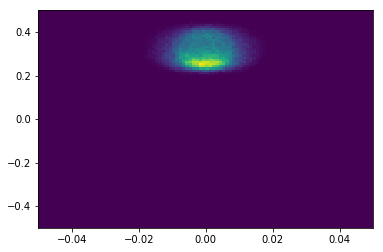

In [132]:

R = -(np.sqrt(mom_lab_frame['p2y']**2+mom_lab_frame['p2z']**2)*1e9)/(1.7*c_)
th_mu = np.arctan(mom_lab_frame['p2y']/mom_lab_frame['p2z'])
mask = th_mu<0

D = 2./np.cos(th_mu)
ct = np.cos(pi/2 - th_mu)
L1 = (-2*R/ct + np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
L2 = (-2*R/ct - np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
d_y = L2**2/(2*R)
d_y[mask] = 0
d_y_1 = d_y/np.sin(pi/2-th_mu) + position['y2']
d_y_1[mask] = 0
L2[mask] = 0

t_out_1 = (L2/R) / omega['mu2']


L = 2./np.cos(th_mu)
tth = np.tan(th_mu)


d1 = (-(2*L*tth-2*R)+np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
d2 = (-(2*L*tth-2*R)-np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
mask = th_mu>0
d_y_2 = d1/np.cos(th_mu) + 2*np.tan(th_mu) + position['y2']
d_y_2[mask] = 0
d1[mask] = 0
L[mask] = 0
t_out_2 = ((L + d1*tth)/R) / omega['mu2']

t_out = t_out_1 + t_out_2


x_out_mu1 = mom_lab_frame['p2x'] * t_out / (mmu * gamma_rel_mu1_arr) + position['x2']
y_out_mu1 = d_y_1 + d_y_2


pos_f = pd.DataFrame({
    'x2': x_out_mu1,
    'y2': y_out_mu1,
    'z2': 2.
})


t_drift = 6./(c_*p_f['p2z']/(mmu*gamma_rel_mu1_arr))

pos_tracker['x2'] = pos_f['x2'] + t_drift * c_*p_f['p2x']/(mmu*gamma_rel_mu1_arr)
pos_tracker['y2'] = pos_f['y2'] + t_drift * c_*p_f['p2y']/(mmu*gamma_rel_mu1_arr)
pos_tracker['z2'] = pos_f['z2'] + t_drift * c_*p_f['p2z']/(mmu*gamma_rel_mu1_arr)


x_arr = np.array(pos_tracker['x1'])
y_arr = np.array(pos_tracker['y1'])
plt.hist2d(x_arr, y_arr, range=((-0.05,0.05),(-0.5,0.5)), bins=100)

In [129]:
pos_tracker

,x1,y1,z1,x2,y2,z2
0,-0.001478,0.293939,8.0,0.013187,-0.311078,8.0
1,0.002632,0.335647,8.0,-0.006968,-0.272442,8.0
2,-0.003839,0.262832,8.0,0.005053,-0.367484,8.0
3,0.004924,0.274287,8.0,-0.009202,-0.338254,8.0
4,0.011023,0.286944,8.0,-0.003901,-0.316093,8.0
5,0.015354,0.328173,8.0,0.002644,-0.279624,8.0
6,-0.001261,0.336988,8.0,-0.009865,-0.291033,8.0
7,0.008156,0.290162,8.0,-0.004482,-0.331050,8.0
8,-0.002191,0.242914,8.0,-0.007276,-0.375688,8.0
9,0.005352,0.275074,8.0,-0.003637,-0.349276,8.0
